I built an ETL pipeline to clean and aggregate household energy consumption data from 2006–2010, then applied Facebook Prophet to forecast future usage. The model captures trends and seasonality, and produces predictions with confidence intervals, which can help in energy demand planning.

In [1]:
# Install required libraries (Colab usually has pandas, numpy pre-installed)
!pip install matplotlib seaborn statsmodels prophet sqlalchemy


In [3]:
from google.colab import files
uploaded = files.upload()   # Upload 'household_power_consumption.txt'


Saving household_power_consumption.txt to household_power_consumption.txt


In [ ]:
# Download the dataset directly from UCI repository
!wget -O household_power_consumption.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip

# Unzip it
!unzip -o household_power_consumption.zip


**EXTRACT**

In [40]:
import pandas as pd

# Read dataset
df = pd.read_csv("household_power_consumption.txt",
                 sep=";",
                 infer_datetime_format=True,
                 na_values=["?"],
                 low_memory=False)

df.tail()


/tmp/ipython-input-2680851116.py:4: FutureWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.



,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.00,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.70,3.8,0.0,0.0,0.0
2075258,26/11/2010,21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0


In [28]:
import pandas as pd

file_path = "/content/drive/MyDrive/ETL_project/employees.csv"
df = pd.read_csv(file_path)

print(df.head())


/tmp/ipython-input-672550179.py:4: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


         Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000            17.0  
4           15.800          0.000          1.000            17.0  


**Transform**

In [32]:
# Convert numeric columns and handle missing values
df = df.dropna()

df = df.astype({"Global_active_power":"float", "Global_reactive_power":"float",
                "Voltage":"float", "Global_intensity":"float"})

# Combine 'Date' index and 'Time' column into a datetime index
df.index = pd.to_datetime(df.index + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')

# Drop the original 'Time' column as it's now part of the index
df = df.drop('Time', axis=1)

# Resample to daily consumption
daily_df = df["Global_active_power"].resample("D").mean()

print(daily_df.head())

2006-12-16    3.053475
2006-12-17    2.354486
2006-12-18    1.530435
2006-12-19    1.157079
2006-12-20    1.545658
Freq: D, Name: Global_active_power, dtype: float64


**Load into Database**

In [33]:
from sqlalchemy import create_engine

# Create SQLite engine
engine = create_engine("sqlite:///energy_data.db")

# Save cleaned daily data into SQL
daily_df.to_frame(name="daily_power").to_sql("energy_consumption", engine, if_exists="replace")

print("Data loaded into SQLite database successfully!")


Data loaded into SQLite database successfully!


**Time Series Forecasting**

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps_mjbqq1/8wuemwwu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps_mjbqq1/gsy8l4df.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=285', 'data', 'file=/tmp/tmps_mjbqq1/8wuemwwu.json', 'init=/tmp/tmps_mjbqq1/gsy8l4df.json', 'output', 'file=/tmp/tmps_mjbqq1/prophet_modelzv4hi83z/prophet_model-20250829042130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:21:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:21:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


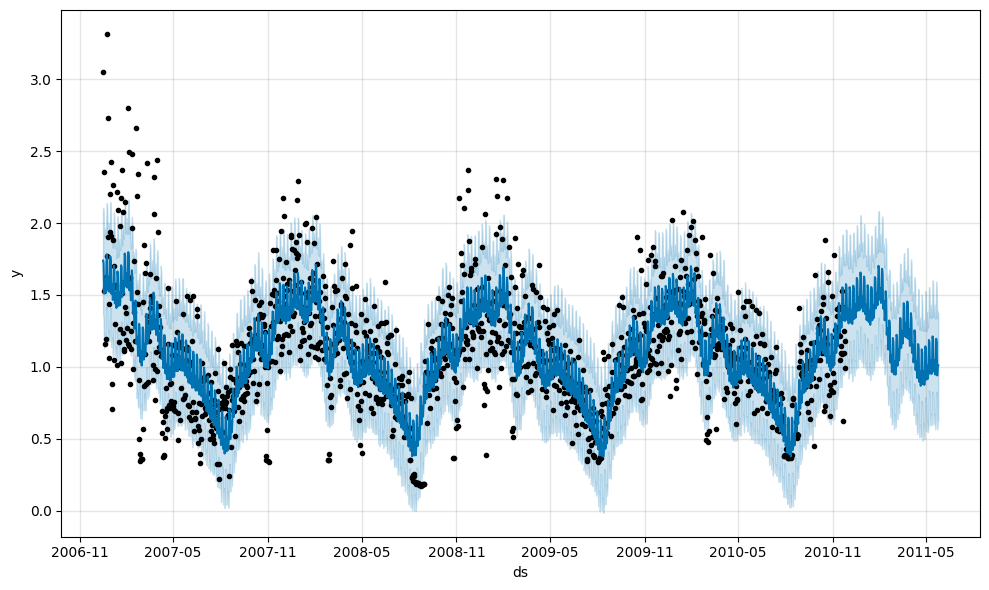

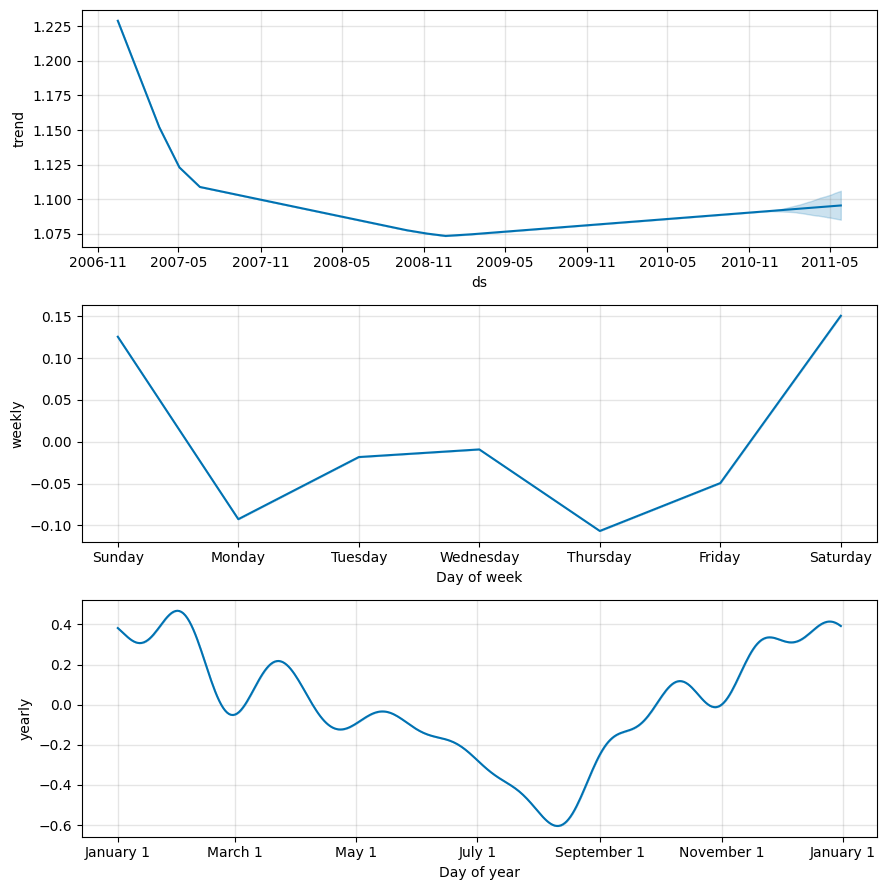

In [55]:
from prophet import Prophet

# Prepare data for Prophet
prophet_df = daily_df.reset_index()
prophet_df.columns = ["ds", "y"]

# Fit model
model = Prophet()
model.fit(prophet_df)

# Forecast next 90 days
future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)

# Plot forecast
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)


**VISUALIZATION**

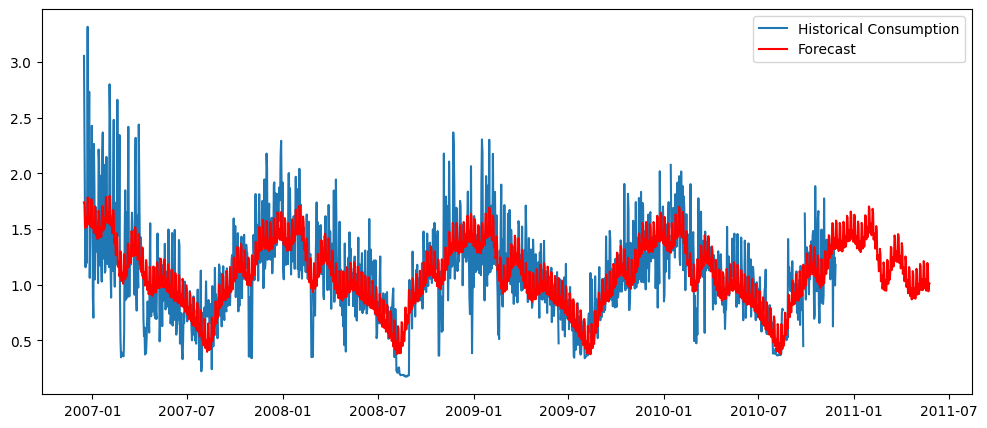

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(daily_df.index, daily_df.values, label="Historical Consumption")
plt.plot(forecast["ds"], forecast["yhat"], label="Forecast", color="red")
plt.legend()
plt.show()


In [57]:
forecast.to_csv("forecast_results.csv", index=False)


In [58]:
result=pd.read_csv("forecast_results.csv")
result.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2006-12-16,1.229064,1.371649,2.106772,1.229064,1.229064,0.509770,0.509770,0.509770,0.150641,0.150641,0.150641,0.359129,0.359129,0.359129,0.0,0.0,0.0,1.738834
1,2006-12-17,1.228234,1.334514,2.078529,1.228234,1.228234,0.493252,0.493252,0.493252,0.125563,0.125563,0.125563,0.367689,0.367689,0.367689,0.0,0.0,0.0,1.721486
2,2006-12-18,1.227403,1.131904,1.907239,1.227403,1.227403,0.283545,0.283545,0.283545,-0.092598,-0.092598,-0.092598,0.376143,0.376143,0.376143,0.0,0.0,0.0,1.510949
3,2006-12-19,1.226573,1.236367,1.968061,1.226573,1.226573,0.365951,0.365951,0.365951,-0.018301,-0.018301,-0.018301,0.384252,0.384252,0.384252,0.0,0.0,0.0,1.592524
4,2006-12-20,1.225743,1.230665,1.953806,1.225743,1.225743,0.382592,0.382592,0.382592,-0.009188,-0.009188,-0.009188,0.391780,0.391780,0.391780,0.0,0.0,0.0,1.608335


In [37]:
files.download("forecast_results.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ds → Date

This is just the timestamp (day, month, year) for each forecasted value.

trend → Overall long-term pattern

Think of it like the general direction of energy usage (increasing, decreasing, or flat over time).

yhat → The main forecast (Predicted value ✅)

This is the number you care about most.

Example: on 16-12-2006, yhat = 1.7388 → that’s the forecasted energy usage.

yhat_lower / yhat_upper → Confidence interval (range)

Prophet gives you a range where the real value is likely to fall.

Example: 1.35 to 2.10 means:

“We are 95% confident the true energy usage will fall in this range.”

additive_terms → Seasonal + holiday + weekly effects combined

Prophet adds together different effects (weekly, yearly, holidays).

weekly → Effect of day-of-week patterns

Example: energy might be higher on weekends → captured here.

yearly → Effect of annual seasonality

Example: winters may have higher usage due to heating.

multiplicative_terms → (If used) multiplicative seasonalities

Yours is all 0, so you didn’t use this option.





In [59]:
from prophet.plot import plot_plotly, plot_components_plotly
fig = plot_plotly(model, forecast)
fig.show()
